The idea is to build a k-d tree for the training set X_train to speed up the nearest neighbour computations for the test set X_test. You are suppoesd to measure the runtimes needed for the training/fitting phase (i.e., for the construction of the tree) as well as for the testing/querying phase (i.e., for the tree traversal that yields the nearest neighbours for a given query point).

In [2]:
%matplotlib inline
import math
import copy
import numpy

In [3]:
def get_datasets(n_train, n_test, dim):
    """ This function generates a training set and
    a test set containing random values. Make use of 
    this function to generate the datasets for your
    experiments.
    """
    
    numpy.random.seed(0)
    
    if n_train is not None:
        X_train = numpy.random.random((n_train, dim))
    else:
        X_train = None
            
    if n_test is not None:
        X_test = numpy.random.random((n_test, dim))
    else:
        X_test = None
    
    return X_train, X_test

In [4]:
class Neighbours():
    """ Class that can be used to keep track of the 
    k nearest neighbours computed. It also conducts
    the "brute-force" phase that takes place in the
    leaves of a k-d tree (see function 'add').
    """

    def __init__(self, k):
        
        self.k = k 
        self._neighbors = [(None, None, float("inf")) for i in range(self.k)]

    def get_dists_indices(self):
        
        indices = [neigh[1] for neigh in self._neighbors]
        dists = [neigh[2] for neigh in self._neighbors]
        
        return numpy.array(dists), numpy.array(indices)
    
    def add(self, points, indices, query):

        for i in range(len(points)):
            
            p = points[i]
            idx = indices[i]
            dist = self._distance(p, query)
            
            self._neighbors.append([p,idx,dist])
            self._neighbors = sorted(self._neighbors, key=lambda n: n[2])
            self._neighbors = self._neighbors[:self.k]

    def get_max_dist(self):
        
        return self._neighbors[-1][2]
        
    def _distance(self, x, y):
        
        dist = 0.0
        for j in range(len(x)):
            dist += (x[j] - y[j])**2
            
        return math.sqrt(dist)
    
class Node():
    """ Class that represents a single node of
    a k-d tree. If both 'left' and 'right' are 
    None, then the node is a leaf. The local 
    variables 'points' and 'indices' are used
    to store the points/indices assigned to a 
    leaf.
    
    Otherwise, it is an internal node that 
    stores the median (splitting hyperplane)
    """
    
    def __init__(self, 
                 left, 
                 right, 
                 median=None, 
                 points=None, 
                 indices=None):

        self.left = left
        self.right = right
        self.median = median
        self.points = points
        self.indices = indices
        
class KDTree():
    
    def __init__(self, leaf_size=30):
        """ Instantiates a k-d tree.
        
        Parameters
        ----------
        leaf_size : int, default 30
            The leaf size, i.e., the maximal 
            number of points stored in a leaf 
            of the k-d tree.
        """
        
        self.leaf_size = leaf_size

    def fit(self, X):
        """
        
        Parameters
        ----------
        X : array-like of shape (n, d)
            A Numpy array containing n data 
            points each having d features                
        """
        
        # remember dimension for which the tree was built
        self._dim = len(X[0])
        
        # generate a list of the "original" indices that
        # are processed in a similar way as the points; 
        # this is needed in order to obtain the indices
        # of the neighbours compuated for a query.
        original_indices = numpy.array(range(len(X)))
        
        # build tree recursively
        self._root = self._build_tree(copy.deepcopy(X),
                                      original_indices, 
                                      depth=0)
        
    def query(self, X, k=1):
        """ Computes the k nearest neighbors for each 
        point in X.
        
        Parameters
        ----------
        X : array-like of shape (n, d)
            A Numpy array containing n data 
            points each having d features
        k : int, default 1
            The number of nearest neighbours to 
            be computed
            
        Returns
        -------
        dists, indices : arrays of shape (n, k)
            Two arrays containing, for each query point,
            the distances and the associated indices of
            its k nearest neighbors w.r.t. the points
            used for building the tree.
        """
        
        if self._root is None:  
            raise Exception("Tree not fitted yet!")
            
        if len(X[0]) != self._dim:
            raise Exception("Tree was fitted for points of dimension: {}".format(self._dim))
        
        # initialize two empty arrays that will be used to 
        # store the distances and the associated indices
        dists = numpy.empty((len(X), k), dtype=numpy.float64)
        indices = numpy.empty((len(X), k), dtype=numpy.int32)
        
        # iterate over all query points
        for i in range(len(X)):

            # initialize the neighbours object, which
            # will keep track of the nearest neighbours
            neighbours = Neighbours(k)
            
            # start recursive search
            self._recursive_search(self._root, 
                                   X[i], 
                                   k, 
                                   depth=0, 
                                   neighbours=neighbours)
            
            # get the final distances and indices for 
            # the current query and store them at 
            # position i in the arrays dists and indices 
            dists_query, indices_query = neighbours.get_dists_indices()
            dists[i,:] = dists_query
            indices[i,:] = indices_query
                
        return dists, indices
    
    def _build_tree(self, pts, indices, depth):
        """ Builds a k-d tree for the points given in pts. Since
        we are also interested in the indidces afterwards, we also
        keep track of the (original) indices.
        
        This code is similar to the pseudocode given on 
        slides 27-29 of L3_LSDA.pdf
        """
        
        # if only self.leaf_size points are left, stop
        # the recursion and generate a leaf node
        if len(pts) <= self.leaf_size: 
            
            return Node(left=None, 
                        right=None, 
                        points=pts, 
                        indices=indices)
        
        # select axis
        axis = depth % self._dim
        
        # sort the points w.r.t. dimension 'axis';
        # also sort the indices accordingly
        partition = pts[:,axis].argsort()
        pts = pts[partition]
        indices = indices[partition]
        
        # compute splitting index and median value
        split_idx = math.floor(len(pts) / 2)
        if len(pts) % 2 == 1:
            median = pts[split_idx, axis]
        else:
            median = 0.5 * (pts[split_idx, axis] + pts[split_idx+1, axis])
        
        # build trees for children recursively ...
        lefttree = self._build_tree(pts[:split_idx,:], indices[:split_idx], depth+1)
        righttree = self._build_tree(pts[split_idx:,:], indices[split_idx:], depth+1)
        
        # return node storing all the relevant information
        return Node(left=lefttree, right=righttree, median=median)

    def _recursive_search(self, node, query, k, depth, neighbours):
        
        if (node.left == None and node.right==None):
            neighbours.add(node.points, node.indices, query)
            return
    
        # axis to be checked (same order as during construction)
        axis = depth % self._dim

        # select next subtree candidate
        if query[axis] < node.median:
            first = node.left
            second = node.right
        else:
            first = node.right
            second = node.left

        # check first subtree
        self._recursive_search(first, query, k, depth+1, neighbours)

        # while going up again (to the root): check if we 
        # still have to search in the second subtree! 
        if abs(node.median - query[axis]) < neighbours.get_max_dist():
            self._recursive_search(second, query, k, depth+1, neighbours)

Let's do a small sanity check by comparing the distances and the indices computed with the ones obtained via the Scikit-Learn implementation.

In [5]:
from sklearn.neighbors import KDTree as KDTreeSK

# generate toy datasets
X_train, X_test = get_datasets(1000, 100, 10)

# our implementation (see above)
tree = KDTree(leaf_size=20)
tree.fit(X_train)
dists, indices = tree.query(X_test, k=3)  

# reference implementation (scikit-learn)
tree = KDTreeSK(X_train, leaf_size=20)  
sk_dists, sk_indices = tree.query(X_test, k=3)

# check if computed arrays are the same
dists_ok = numpy.allclose(dists, sk_dists)
indices_ok = numpy.allclose(indices, sk_indices)
print("Distances correct: {}".format(dists_ok))
print("Indices correct: {}".format(dists_ok))

Distances correct: True
Indices correct: True


**Practical Runtimes (a):** Analyze the runtime behaviour for the training/fitting phase given different dimensions of the feature space and given an increasing amount of training points. Your plot (n_train vs. runtime) should generate 5 graphs, one for each dim=5,10,15,20,25. 

Processing patterns of dimension 5 ...
Processing patterns of dimension 10 ...
Processing patterns of dimension 15 ...
Processing patterns of dimension 20 ...
Processing patterns of dimension 25 ...


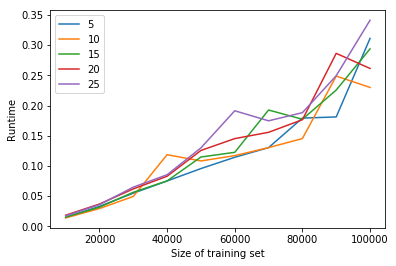

In [14]:
import time
import matplotlib.pyplot as plt

n_trains = [i*10000 for i in range(1,11)]
dims = [5,10,15,20,25]

fig, ax = plt.subplots()

for dim in dims:

    print("Processing patterns of dimension {} ...".format(dim))

    # YOUR RUNTIME MEASUREMENTS AND GRAPHS HERE 
    #
    # for each n_train in n_trains, do
    # - generate training set X_train of size n_train and dimensionality dim
    # - create a k-d tree object tree
    # - measure time needed for tree.fit(X_train)
    # - create runtime graph; all graphs should be in the same plot
    t = []
    for n in n_trains:
        Xtrain, Xtest = get_datasets(n, 100, dim)
        tree = KDTree(leaf_size = 20)
        start = time.clock()
        tree.fit(Xtrain)
        elapsed = time.clock() - start
        t.append(elapsed)
    plt.plot(n_trains, t, label = dim)
        
ax.legend()
plt.xlabel('Size of training set')
plt.ylabel('Runtime')
plt.show()

**Practical Runtimes (b):** Analyze the runtime behaviour for the testing/querying phase given different dimensions of the feature space and given an increasing amount of test points. Your plot (n_test vs. runtime) should generate 5 graphs, one for each dim=5,10,15,20,25. 

Processing patterns of dimension 5 ...
Processing patterns of dimension 10 ...
Processing patterns of dimension 15 ...
Processing patterns of dimension 20 ...
Processing patterns of dimension 25 ...


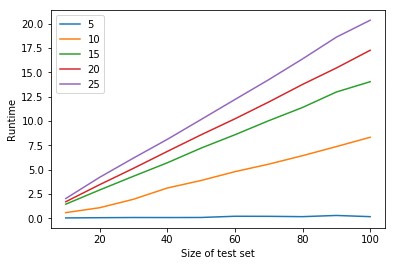

In [17]:
n_train = 10000
n_tests = [i*10 for i in range(1,11)]
dims = [5,10,15,20,25]

# YOUR RUNTIME MEASUREMENTS AND GRAPHS HERE 
# (note: the runtime experiment might take some minutes)
for dim in dims:

    print("Processing patterns of dimension {} ...".format(dim))

    # YOUR RUNTIME MEASUREMENTS AND GRAPHS HERE 
    #
    # for each n_train in n_trains, do
    # - generate training set X_train of size n_train and dimensionality dim
    # - create a k-d tree object tree
    # - measure time needed for tree.fit(X_train)
    # - create runtime graph; all graphs should be in the same plot
    t = []
    for n in n_tests:
        Xtrain, Xtest = get_datasets(n_train, n, dim)
        tree = KDTree(leaf_size = 20)
        tree.fit(Xtrain)
        start = time.clock()
        dists, indices = tree.query(Xtest, k=3)  
        elapsed = time.clock() - start
        t.append(elapsed)
    plt.plot(n_tests, t, label = dim)
        
plt.legend()
plt.xlabel('Size of test set')
plt.ylabel('Runtime')
plt.show()

**Runtime Profiling:** Make use of the cProfile module to profile the query phase.

In [19]:
import cProfile

X_train, X_test = get_datasets(10000, 100, 50)

# YOUR CODE HERE
tree = KDTree(leaf_size = 20)
tree.fit(Xtrain)
cProfile.run('tree.query(Xtest, k=3)')

         9307610 function calls (9205410 primitive calls) in 23.449 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002   23.448   23.448 <ipython-input-4-5973250f7d7a>:108(query)
      100    0.001    0.000    0.001    0.000 <ipython-input-4-5973250f7d7a>:11(<listcomp>)
      100    0.001    0.000    0.002    0.000 <ipython-input-4-5973250f7d7a>:13(get_dists_indices)
      100    0.000    0.000    0.000    0.000 <ipython-input-4-5973250f7d7a>:15(<listcomp>)
      100    0.000    0.000    0.000    0.000 <ipython-input-4-5973250f7d7a>:16(<listcomp>)
    51200    2.455    0.000   23.106    0.000 <ipython-input-4-5973250f7d7a>:20(add)
102300/100    0.289    0.000   23.443    0.234 <ipython-input-4-5973250f7d7a>:205(_recursive_search)
  4000000    0.519    0.000    0.519    0.000 <ipython-input-4-5973250f7d7a>:29(<lambda>)
    51100    0.037    0.000    0.037    0.000 <ipython-input-4-5973250f7d7a>:32(ge